In [1]:
import re
import random

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.spatial.distance import cosine
from scipy.stats import entropy

# Reading and Preprocessing Data

The radius for Ripley's \( k \) is calculated using the following formula:
$$ r = \text{grid\_size} \times \frac{\sqrt{2}}{3} $$
Hence, the following table:

| grid_size | r   |
|-----------|-----|
| 250       | 117 |
| 125       | 58  |
| 62.5      | 30  |
| 50        | 23  |
| 31.25     | 14  |


In [2]:
def convert_string_to_np(string):
    numbers = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", string)
    float_numbers = [float(num) for num in numbers]
    size = int(np.sqrt(len(float_numbers)))
    return np.array(float_numbers).reshape((size, size))

In [3]:
def preprocess_df (df):
    df['y'] = df['y'].apply(lambda x: convert_string_to_np(x))
    df['y_hat'] = df['y_hat'].apply(lambda x: convert_string_to_np(x))
    df['grid_num'] = df['grid_num'].apply(lambda x: int(x.split('_')[0]))
    if 'subset' in df.columns:
        df['subset'] = df['subset'].apply(lambda x: list(eval(x)))
    return df

In [4]:
main_df = preprocess_df(pd.read_csv('main_all_regressors.csv'))

# Main Analysis

## Performance Measures

In [5]:
def calculate_performance(row):
    y = row['y']
    y_hat = row['y_hat']
    total_active_cells = row['total_active_cells']
    
    output = {
        'mae': dict(),
        'rmse': dict(),
        'r2': dict(),
        'kl_divergence': dict(),
    }

    AP_sum_true = np.sum(y, axis=1)
    AP_sum_pred = np.sum(y_hat, axis=1)
    
    DV_sum_true = np.sum(y, axis=0)
    DV_sum_pred = np.sum(y_hat, axis=0)

    # Mean Absolute Error
    output['mae']['grid'] = np.mean(np.abs(y - y_hat))
    output['mae']['AP'] = np.mean(np.abs(AP_sum_true - AP_sum_pred))
    output['mae']['DV'] = np.mean(np.abs(DV_sum_true - DV_sum_pred))

    # Root Mean Squared Error
    output['rmse']['grid'] = np.sqrt(mean_squared_error(y, y_hat))
    output['rmse']['AP'] = np.sqrt(mean_squared_error(AP_sum_true, AP_sum_pred))
    output['rmse']['DV'] = np.sqrt(mean_squared_error(DV_sum_true, DV_sum_pred))
    
    # R-squared
    output['r2']['grid'] = r2_score(y, y_hat)
    output['r2']['AP'] = r2_score(AP_sum_true, AP_sum_pred)
    output['r2']['DV'] = r2_score(DV_sum_true, DV_sum_pred)
    
    # KL Divergence - first ensure no zero values and normalize to create distributions
    epsilon = 1e-10
    grid_true = (y + epsilon) / (np.sum(y) + epsilon * len(y))
    grid_pred = (y_hat + epsilon) / (np.sum(y_hat) + epsilon * len(y_hat))
    
    AP_sum_true = (AP_sum_true + epsilon) / (np.sum(AP_sum_true) + epsilon * len(AP_sum_true))
    AP_sum_pred = (AP_sum_pred + epsilon) / (np.sum(AP_sum_pred) + epsilon * len(AP_sum_pred))
    
    DV_sum_true = (DV_sum_true + epsilon) / (np.sum(DV_sum_true) + epsilon * len(DV_sum_true))
    DV_sum_pred = (DV_sum_pred + epsilon) / (np.sum(DV_sum_pred) + epsilon * len(DV_sum_pred))

    output['kl_divergence']['grid'] = np.mean(entropy(grid_true, grid_pred))
    output['kl_divergence']['AP'] = entropy(AP_sum_true, AP_sum_pred)
    output['kl_divergence']['DV'] = entropy(DV_sum_true, DV_sum_pred)

    return output

In [6]:
performance_metrics = ['mae', 'rmse', 'r2', 'kl_divergence']

for metric in performance_metrics:
    main_df[f"grid_{metric}"] = main_df.apply(lambda x: calculate_performance(x)[metric]['grid'], axis=1)
    main_df[f"AP_{metric}"] = main_df.apply(lambda x: calculate_performance(x)[metric]['AP'], axis=1)
    main_df[f"DV_{metric}"] = main_df.apply(lambda x: calculate_performance(x)[metric]['DV'], axis=1)

## Optimal Number of Grids

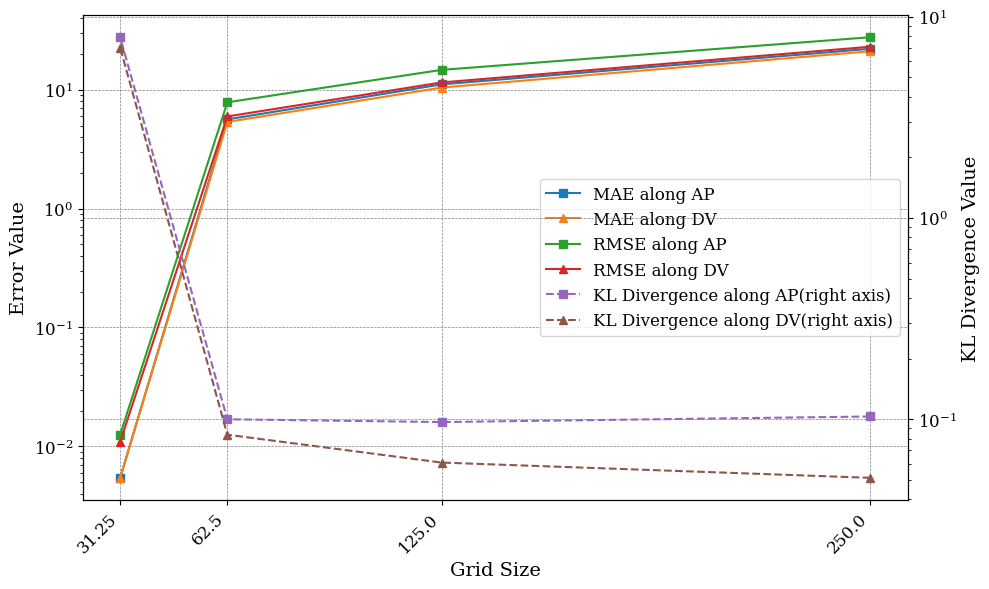

In [19]:
performance_metrics = ['mae', 'rmse', 'kl_divergence']
metric_names = {
    'mae': 'MAE',
    'rmse': 'RMSE',
    'kl_divergence': 'KL Divergence',
}

grouped_columns = [col for col in main_df.columns if col not in ['video_id', 'stage', 'y', 'y_hat']]

# Customize the style
# sns.set_theme(style="darkgrid")
plt.rc('axes', titlesize=18)     # Axes title
plt.rc('axes', labelsize=14)     # x and y labels
plt.rc('xtick', labelsize=12)    # x tick labels
plt.rc('ytick', labelsize=12)    # y tick labels
plt.rc('legend', fontsize=12)    # legend
plt.rc('font', family='serif')

# Create a single figure and primary axis
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
ax1.set_yscale('log')
ax1.set_xscale('linear')
lines, labels = [], []

grouped = main_df[grouped_columns].groupby(['grid_num']).mean().reset_index()

# Now set the major x ticks to the grid numbers
ax1.set_xticks(1000 / grouped['grid_num'])
ax1.set_xticklabels(1000 / grouped['grid_num'], rotation=45, ha='right')  # Rotate for better readability if needed

metric = 'mae'
line = ax1.plot(1000 / grouped['grid_num'], grouped[f"AP_{metric}"], marker='s', label=f"{metric_names[metric]} along AP")
lines += line
line = ax1.plot(1000 / grouped['grid_num'], grouped[f"DV_{metric}"], marker='^', label=f"{metric_names[metric]} along DV")
lines += line

metric = 'rmse'
line = ax1.plot(1000 / grouped['grid_num'], grouped[f"AP_{metric}"], marker='s', label=f"{metric_names[metric]} along AP")
lines += line
line = ax1.plot(1000 / grouped['grid_num'], grouped[f"DV_{metric}"], marker='^', label=f"{metric_names[metric]} along DV")
lines += line
ax1.set_xlabel('Grid Size')
ax1.set_ylabel('Error Value')
ax1.grid(False)
ax1.grid(True, which='major', linestyle='--', color='gray', linewidth=0.5)

metric = 'kl_divergence'
ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.set_yscale('log')
line = ax2.plot(1000 / grouped['grid_num'], grouped[f"AP_{metric}"], color='C4', marker='s', linestyle='--', label=f"{metric_names[metric]} along AP(right axis)")
lines += line
line = ax2.plot(1000 / grouped['grid_num'], grouped[f"DV_{metric}"], color='C5', marker='^', linestyle='--', label=f"{metric_names[metric]} along DV(right axis)")
lines += line
ax2.set_ylabel('KL Divergence Value')
ax2.grid(False)
ax2.grid(True, which='major', linestyle='--', color='gray', linewidth=0.5)

# Collect the handles and labels from both axes
handles, labels = [], []
for ax in [ax1, ax2]:
    ax_handles, ax_labels = ax.get_legend_handles_labels()
    handles.extend(ax_handles)
    labels.extend(ax_labels)

# Place a single legend on the plot
ax1.legend(handles, labels, loc='center right', fancybox=True)

# After the loop, adjust the layout and show the plot
# plt.grid(False)
plt.tight_layout()
plt.savefig(f"grid_search.pdf", dpi=300, bbox_inches='tight')
# plt.savefig(f"grid_search.eps", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
x = pd.read_csv('all.csv')
print(f"average cell size is {x['size'].apply(lambda x: np.sqrt(x)).mean()} pixels.")

average cell size is 36.14976657219771 pixels.
